# **Google Play Store Apps** - Data Analysis

This notebook includes the procedure of making a descriptive analysis of google play store apps data obtained from [Kaggle](https://www.kaggle.com/datasets/lava18/google-play-store-apps) and cleaned previously.

## 1) Import Libraries

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from IPython.display import display_html
from packaging.version import parse, Version, LegacyVersion
from packaging.utils import canonicalize_version
import os, re, warnings

## 2) Load Dataframes

In [2]:
# load stored dataframes
%store -r

In [3]:
df_feature.columns

Index(['app', 'category', 'rating', 'reviews', 'size', 'installs', 'type',
       'price', 'content_rating', 'genres', 'update_year', 'update_month',
       'update_day', 'update_weekday', 'last_updated', 'current_ver',
       'android_ver'],
      dtype='object')

In [4]:
# column subset for shorter view
shorter = ['app', 'category', 'rating', 'reviews', 'size', 'installs', 'type',\
           'price', 'content_rating', 'genres', 'last_updated', 'current_ver',\
           'android_ver']

# full feature dataframe
df_feature[shorter].head(3)

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19.0,10000.0,Free,0.0,Everyone,"[Art, Design]",2018-01-07,1,4.0.3
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14.0,500000.0,Free,0.0,Everyone,"[Pretend Play, Art, Design]",2018-01-15,2,4.0.3
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,8.7,5000000.0,Free,0.0,Everyone,"[Art, Design]",2018-08-01,1.2.4,4.0.3


In [5]:
# full review dataframe
df_review.head(3)

,app,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000


In [6]:
# outer merged dataframe
result_outer.head(3)

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,...,update_month,update_day,update_weekday,last_updated,current_ver,android_ver,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity
0,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14.0,500000.0,Free,0.0,Everyone,"[Pretend Play, Art, Design]",...,1.0,15.0,Monday,2018-01-15,2,4.0.3,A kid's excessive ads. The types ads allowed a...,Negative,-0.250,1.000000
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14.0,500000.0,Free,0.0,Everyone,"[Pretend Play, Art, Design]",...,1.0,15.0,Monday,2018-01-15,2,4.0.3,It bad >:(,Negative,-0.725,0.833333
2,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14.0,500000.0,Free,0.0,Everyone,"[Pretend Play, Art, Design]",...,1.0,15.0,Monday,2018-01-15,2,4.0.3,like,Neutral,0.000,0.000000


In [7]:
result_outer.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28250 entries, 0 to 28249
Columns: 21 entries, app to sentiment_subjectivity
dtypes: datetime64[ns](1), float64(10), object(10)
memory usage: 4.7+ MB


In [8]:
# average merged dataframe
result_avg.head(3)

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver,sentiment,sentiment_polarity,sentiment_subjectivity
0,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14.0,500000.0,Free,0.0,Everyone,"[Pretend Play, Art, Design]",2018.0,1.0,15.0,Monday,2018-01-15,2,4.0.3,Positive,0.117917,0.645694
1,Garden Coloring Book,ART_AND_DESIGN,4.4,13791.0,33.0,1000000.0,Free,0.0,Everyone,"[Art, Design]",2017.0,9.0,20.0,Wednesday,2017-09-20,2.9.2,3,Positive,0.268483,0.523447
2,FlipaClip - Cartoon animation,ART_AND_DESIGN,4.3,194216.0,39.0,5000000.0,Free,0.0,Everyone,"[Art, Design]",2018.0,8.0,3.0,Friday,2018-08-03,2.2.5,4.0.3,Positive,0.412649,0.679226


In [9]:
result_avg.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816 entries, 0 to 815
Columns: 20 entries, app to sentiment_subjectivity
dtypes: datetime64[ns](1), float64(10), object(9)
memory usage: 133.9+ KB


## 3) General Analysis

From this part of the analysis, we can extract some significant data concerning the overall world of apps. 
- which apps are the most downloaded/most popular?
- which are the driving categories? What's the category ranking in terms of installs? And in terms of rating? Does more downloads = better rating? Why?
- do sentiments and ratings combine? Are they consistent?


- on which days are users more likely to download apps? On weekend? Or during weekdays? What could be the reason?
- on which months are users more likely to download apps? And which categories? (eg. diet before summer) What could be the reason?


- which category is associated to the most/least number of apps? In the latter case, how are installs and reviews? Does less associated apps = worse quality? Why?


- what is the average price for paid apps? Use both mean() and median(). There is one or more big outlier(s). Let's see how they affect our statistics and decide whether we want to get rid of it/them or not. (For this specific task, let's use whisker/violin/scatter plots to highlight the outliers (maybe with scatter?) and the std before and after removing them (violin?)). 


- which apps were not updated in year 2018? What was the overall sentiment/pölarity for those apps? Could it mean they were abandoned? Or that they are going to be improved in the future?


- Is there a specific content ranking category that seems to be expressing more negative sentiment towards apps in general? If so, which one(s)?
- Is there an overall correlation between free and positive sentiment or paid and negative sentiment?


- Which apps categories (top 5?) have a larger mean size? Are those categories similar or are they totally differnt?
- Are there outliers or is the distribution homogenous? (great chance o use scatter plots here!)
- Is there any correlation between the size of the app and the installs? Do people overall prefer installing smaller apps?

### 3.1) Who are the winners?

In [10]:
# top most downloaded apps:
most_downloaded = result_avg.sort_values(['installs'], ascending=False).head(5)
most_downloaded

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver,sentiment,sentiment_polarity,sentiment_subjectivity
61,Gmail,COMMUNICATION,4.3,4604324.0,NaN,1.000000e+09,Free,0.0,Everyone,[Communication],2018.0,8.0,2.0,Thursday,2018-08-02,Varies,Varies,Positive,0.058016,0.456138
62,Hangouts,COMMUNICATION,4.0,3419249.0,NaN,1.000000e+09,Free,0.0,Everyone,[Communication],2018.0,7.0,21.0,Saturday,2018-07-21,Varies,Varies,Positive,0.239355,0.525005
478,Facebook,SOCIAL,4.1,78158306.0,NaN,1.000000e+09,Free,0.0,Teen,[Social],2018.0,8.0,3.0,Friday,2018-08-03,Varies,Varies,Negative,-0.005909,0.460871
617,Google,TOOLS,4.4,8033493.0,NaN,1.000000e+09,Free,0.0,Everyone,[Tools],2018.0,8.0,3.0,Friday,2018-08-03,Varies,Varies,Positive,0.260359,0.492744
518,Google Photos,PHOTOGRAPHY,4.5,10858556.0,NaN,1.000000e+09,Free,0.0,Everyone,[Photography],2018.0,8.0,6.0,Monday,2018-08-06,Varies,Varies,Positive,0.187021,0.509305


In [11]:
# top most reviewed apps:
highest_review = result_avg.sort_values(['reviews'],ascending=False).head(5)
highest_review

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver,sentiment,sentiment_polarity,sentiment_subjectivity
478,Facebook,SOCIAL,4.1,78158306.0,NaN,1.000000e+09,Free,0.0,Teen,[Social],2018.0,8.0,3.0,Friday,2018-08-03,Varies,Varies,Negative,-0.005909,0.460871
326,Clash of Clans,GAME,4.6,44891723.0,98.0,1.000000e+08,Free,0.0,Everyone 10+,[Strategy],2018.0,7.0,15.0,Sunday,2018-07-15,10.322.16,4.1,Positive,0.040001,0.534977
321,Clash Royale,GAME,4.6,23133508.0,97.0,1.000000e+08,Free,0.0,Everyone 10+,[Strategy],2018.0,6.0,27.0,Wednesday,2018-06-27,2.3.2,4.1,Positive,0.046237,0.484853
318,Candy Crush Saga,GAME,4.4,22426677.0,74.0,5.000000e+08,Free,0.0,Everyone,[Casual],2018.0,7.0,5.0,Thursday,2018-07-05,1.129.0.2,4.1,Positive,0.031068,0.456293
328,8 Ball Pool,GAME,4.5,14198297.0,52.0,1.000000e+08,Free,0.0,Everyone,[Sports],2018.0,7.0,31.0,Tuesday,2018-07-31,4,4.0.3,Positive,0.008782,0.508397


In [12]:
# top most rated apps:
highest_rated = result_avg.sort_values(['rating'],ascending=False).head(5)
highest_rated

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver,sentiment,sentiment_polarity,sentiment_subjectivity
12,DMV Permit Practice Test 2018 Edition,AUTO_AND_VEHICLES,4.9,6090.0,27.0,100000.0,Free,0.0,Everyone,"[Auto, Vehicles]",2018.0,7.0,3.0,Tuesday,2018-07-03,1.7,4.2,Positive,0.295660,0.559806
253,Down Dog: Great Yoga Anywhere,HEALTH_AND_FITNESS,4.9,28945.0,12.0,500000.0,Free,0.0,Teen,"[Fitness, Health]",2018.0,5.0,17.0,Thursday,2018-05-17,2.6.1,4.2,Positive,0.291847,0.526837
10,CDL Practice Test 2018 Edition,AUTO_AND_VEHICLES,4.9,7774.0,17.0,100000.0,Free,0.0,Everyone,"[Auto, Vehicles]",2018.0,7.0,3.0,Tuesday,2018-07-03,1.7,4.2,Positive,0.241126,0.477825
234,Home Workout for Men - Bodybuilding,HEALTH_AND_FITNESS,4.8,12705.0,15.0,1000000.0,Free,0.0,Everyone,"[Fitness, Health]",2018.0,7.0,10.0,Tuesday,2018-07-10,1.0.2,4,Positive,0.504387,0.476908
516,FreePrints – Free Photos Delivered,PHOTOGRAPHY,4.8,109500.0,37.0,1000000.0,Free,0.0,Everyone,[Photography],2018.0,8.0,2.0,Thursday,2018-08-02,2.18.2,4.1,Positive,0.446181,0.626680


In [13]:
warnings.simplefilter(action='ignore', category=FutureWarning)

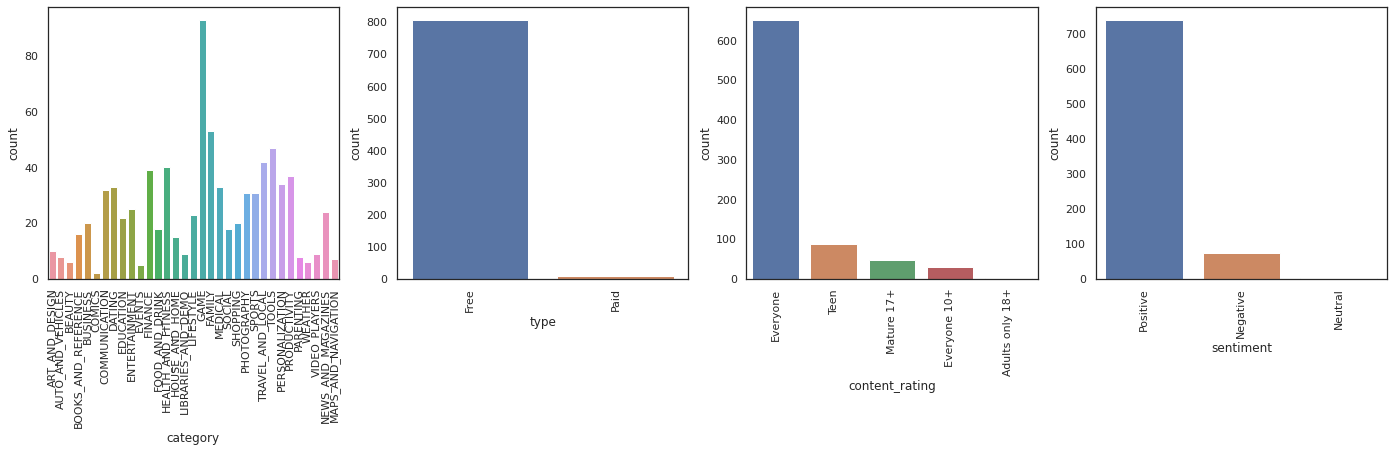

In [14]:
# count plots of selected categorical columns
categorical = ['category', 'type', 'content_rating', 'sentiment']

sns.set_theme(style="white")
fig, ax = plt.subplots(1, 4, figsize=(24, 5))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(result_avg[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

Unsurprisingly, the most downloaded apps concern social media and communication. Interestingly enough - with the exception of Facebook - the most reviewed apps are games ones. The highest rated apps, on the other hand, do not include any super famous name.


From the graphs above, we can see that:
- 'game' is by far the category with the most associated apps, followed by 'family', 'tools' and 'travel and local'.
- the vast majority of apps is free to download
- the vast majority of apps is accessible by everyone
- the great majority of people writes positive reviews

### 3.2) When do developers update apps?

In [15]:
#which weekdays are chosen for updates
download_by_weekdays=result_avg.value_counts(['update_weekday'], ascending=False).head(5)
download_by_weekdays

update_weekday
Thursday          161
Friday            154
Tuesday           152
Monday            136
Wednesday         130
dtype: int64

In [16]:
#which months are chosen for updates
download_by_months=result_avg.value_counts(['update_month'], ascending=False).head(5)
download_by_months

update_month
7.0             347
8.0             167
6.0              93
5.0              56
4.0              37
dtype: int64

In [ ]:
#which app categories are most downloaded in july and august

### 3.3) How does the number of app per category affect?

We know from the graphs at section 3.1 that 'game','family' and 'beauty' are the top 3 categories for associated apps.
In contrast, 'comics', 'events' and 'weather' are the bottom 3. 

In [ ]:
#Display bottom 3 categories in terms of associated apps and check

### 3.4) Price analysis

what is the average price for paid apps? Use both mean() and median(). There is one or more big outlier(s). Let's see how they affect our statistics and decide whether we want to get rid of it/them or not. (For this specific task, let's use whisker/violin/scatter plots to highlight the outliers (maybe with scatter?) and the std before and after removing them (violin?)).

In [59]:
#creating a sub-dataframe with paid apps only 
paid_apps=df_feature[df_feature.type=='Paid']
paid_apps

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver
234,TurboScan: scan documents and receipts in PDF,BUSINESS,4.700000,11442.0,6.8,100000.0,Paid,4.99,Everyone,[Business],2018.0,3.0,25.0,Sunday,2018-03-25,1.5.2,4
235,Tiny Scanner Pro: PDF Doc Scan,BUSINESS,4.800000,10295.0,39.0,100000.0,Paid,4.99,Everyone,[Business],2017.0,4.0,11.0,Tuesday,2017-04-11,3.4.6,3
290,TurboScan: scan documents and receipts in PDF,BUSINESS,4.700000,11442.0,6.8,100000.0,Paid,4.99,Everyone,[Business],2018.0,3.0,25.0,Sunday,2018-03-25,1.5.2,4
291,Tiny Scanner Pro: PDF Doc Scan,BUSINESS,4.800000,10295.0,39.0,100000.0,Paid,4.99,Everyone,[Business],2017.0,4.0,11.0,Tuesday,2017-04-11,3.4.6,3
427,Puffin Browser Pro,COMMUNICATION,4.000000,18247.0,NaN,100000.0,Paid,3.99,Everyone,[Communication],2018.0,7.0,5.0,Thursday,2018-07-05,7.5.3.20547,4.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10735,FP VoiceBot,FAMILY,4.191847,17.0,NaN,100.0,Paid,0.99,Mature 17+,[Entertainment],2015.0,11.0,25.0,Wednesday,2015-11-25,1.2,2.1
10760,Fast Tract Diet,HEALTH_AND_FITNESS,4.400000,35.0,2.4,1000.0,Paid,7.99,Everyone,"[Fitness, Health]",2018.0,8.0,8.0,Wednesday,2018-08-08,1.9.3,4.2
10782,Trine 2: Complete Story,GAME,3.800000,252.0,11.0,10000.0,Paid,16.99,Teen,[Action],2015.0,2.0,27.0,Friday,2015-02-27,2.22,5
10785,"sugar, sugar",FAMILY,4.200000,1405.0,9.5,10000.0,Paid,1.20,Everyone,[Puzzle],2018.0,6.0,5.0,Tuesday,2018-06-05,2.7,2.3


In [61]:
#display mean and median of the new dataframe
paid_apps.price.agg(['min','max','mean','median','std'])

min         0.990000
max       400.000000
mean       13.968883
median      2.990000
std        57.297657
Name: price, dtype: float64

<AxesSubplot:xlabel='price'>

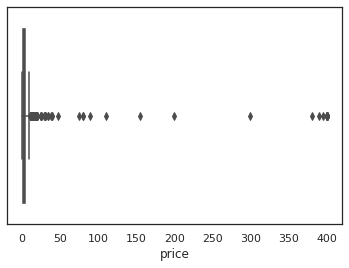

In [64]:
sns.set_theme(style='white')
sns.boxplot(data=paid_apps, x="price")

The difference between mean and median, the huge standard deviation and the boxplot show us that there are a few outliers which drastically affect our price column. For this reason, we decided to get rid of those outliers. If we use the result_avg dataframe instead, we can see that the values are definitely more homogenous.

In [65]:
#using the result_avg dataframe
result_avg.price.agg(['min','max','mean','median','std'])

min        0.000000
max       29.990000
mean       0.099767
median     0.000000
std        1.278179
Name: price, dtype: float64

<AxesSubplot:xlabel='price'>

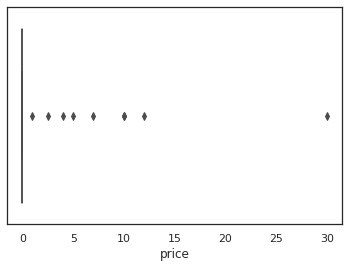

In [66]:
sns.set_theme(style='white')
sns.boxplot(data=result_avg, x="price")

### 3.5) Why are some apps lagging behind?

which apps were not updated in year 2018? What was the overall sentiment/pölarity for those apps? Could it mean they were abandoned? Or that they are going to be improved in the future?

In [38]:
#creating a new sub-dataframe with apps which were not updated in year 2018
not_updated=result_avg[result_avg.update_year!=2018.0]
not_updated

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver,sentiment,sentiment_polarity,sentiment_subjectivity
1,Garden Coloring Book,ART_AND_DESIGN,4.4,13791.0,33.0,1000000.0,Free,0.0,Everyone,"[Art, Design]",2017.0,9.0,20.0,Wednesday,2017-09-20,2.9.2,3,Positive,0.268483,0.523447
4,Colorfit - Drawing & Coloring,ART_AND_DESIGN,4.7,20260.0,25.0,500000.0,Free,0.0,Everyone,"[Creativity, Art, Design]",2017.0,10.0,11.0,Wednesday,2017-10-11,1.0.8,4.0.3,Positive,0.171836,0.572762
21,Beauty Camera - Selfie Camera,BEAUTY,4.0,113715.0,NaN,10000000.0,Free,0.0,Everyone,[Beauty],2017.0,8.0,3.0,Thursday,2017-08-03,Varies,Varies,Positive,0.199994,0.450820
23,Dresses Ideas & Fashions +3000,BEAUTY,4.5,473.0,8.2,100000.0,Free,0.0,Mature 17+,[Beauty],2017.0,3.0,1.0,Wednesday,2017-03-01,1.0.2,1.6,Positive,0.430603,0.557467
25,Cool Reader,BOOKS_AND_REFERENCE,4.5,246315.0,NaN,10000000.0,Free,0.0,Everyone,"[Reference, Books]",2015.0,7.0,17.0,Friday,2015-07-17,Varies,1.5,Positive,0.115841,0.477370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,Draw A Stickman,GAME,3.4,29265.0,17.0,1000000.0,Free,0.0,Everyone,[Adventure],2017.0,5.0,19.0,Friday,2017-05-19,1.1,4.0.3,Negative,-0.150000,0.400000
802,Be A Legend: Soccer,SPORTS,3.8,85763.0,21.0,1000000.0,Free,0.0,Everyone,[Sports],2015.0,8.0,24.0,Monday,2015-08-24,2.8.0.17,3,Negative,-0.099251,0.474397
805,Four In A Line,GAME,3.8,22191.0,3.0,1000000.0,Free,0.0,Everyone,[Board],2015.0,5.0,4.0,Monday,2015-05-04,1.10,2.3,Positive,0.274849,0.549317
809,Bad Piggies,FAMILY,4.3,1168959.0,66.0,50000000.0,Free,0.0,Everyone,[Puzzle],2017.0,5.0,3.0,Wednesday,2017-05-03,2.3.3,4.1,Positive,0.007941,0.538949


In [57]:
#what is the sentiment over these not updated apps?
not_updated.sentiment.value_counts() / len(not_updated)

Positive    0.89781
Negative    0.10219
Name: sentiment, dtype: float64

In [ ]:
#what is the sentiment polarity?
not_updated.sentiment_polarity.agg(['mean','median'])

### 3.6) Does free=positive reviews and paid=negative reviews?


Is there an overall correlation between free and positive sentiment or paid and negative sentiment?

In [70]:
free_apps=result_avg[result_avg.type=='Free']
free_apps

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver,sentiment,sentiment_polarity,sentiment_subjectivity
0,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14.0,500000.0,Free,0.0,Everyone,"[Pretend Play, Art, Design]",2018.0,1.0,15.0,Monday,2018-01-15,2,4.0.3,Positive,0.117917,0.645694
1,Garden Coloring Book,ART_AND_DESIGN,4.4,13791.0,33.0,1000000.0,Free,0.0,Everyone,"[Art, Design]",2017.0,9.0,20.0,Wednesday,2017-09-20,2.9.2,3,Positive,0.268483,0.523447
2,FlipaClip - Cartoon animation,ART_AND_DESIGN,4.3,194216.0,39.0,5000000.0,Free,0.0,Everyone,"[Art, Design]",2018.0,8.0,3.0,Friday,2018-08-03,2.2.5,4.0.3,Positive,0.412649,0.679226
3,Boys Photo Editor - Six Pack & Men's Suit,ART_AND_DESIGN,4.1,654.0,12.0,100000.0,Free,0.0,Everyone,"[Art, Design]",2018.0,3.0,20.0,Tuesday,2018-03-20,1.1,4.0.3,Positive,0.260370,0.472593
4,Colorfit - Drawing & Coloring,ART_AND_DESIGN,4.7,20260.0,25.0,500000.0,Free,0.0,Everyone,"[Creativity, Art, Design]",2017.0,10.0,11.0,Wednesday,2017-10-11,1.0.8,4.0.3,Positive,0.171836,0.572762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,"AD - Nieuws, Sport, Regio & Entertainment",NEWS_AND_MAGAZINES,3.7,10369.0,NaN,1000000.0,Free,0.0,Everyone,"[News, Magazines]",2018.0,7.0,28.0,Saturday,2018-07-28,Varies,Varies,Positive,0.161824,0.465806
812,AppLock,TOOLS,4.4,4931562.0,NaN,100000000.0,Free,0.0,Everyone,[Tools],2018.0,6.0,11.0,Monday,2018-06-11,Varies,Varies,Positive,0.016233,0.499941
813,Diary with lock password,LIFESTYLE,4.3,179139.0,9.7,5000000.0,Free,0.0,Everyone,[Lifestyle],2017.0,11.0,1.0,Wednesday,2017-11-01,3.5.3,4.0.3,Positive,0.292267,0.509656
814,Avakin Life - 3D virtual world,FAMILY,4.4,1275373.0,91.0,10000000.0,Free,0.0,Teen,[Role Playing],2018.0,7.0,3.0,Tuesday,2018-07-03,1.21.10,4.1,Positive,0.080859,0.505326


In [74]:
#checking positive, negative and neutral distribution for the free_apps
free_apps.sentiment.value_counts() / len(free_apps)    

Positive    0.908302
Negative    0.089219
Neutral     0.002478
Name: sentiment, dtype: float64

In [73]:
#after deleting the outliers, use the new paid_apps dataset and check the same values

### 3.6) Who are the happiest users?

Is there a specific content ranking category that seems to be expressing more negative sentiment towards apps in general? If so, which one(s)?

In [91]:
#which content rating cateogry has expressed the highest number of ratings
result_avg.groupby(['content_rating'])['rating'].sum().sort_values(ascending=False).head(10)


content_rating
Everyone           2792.2
Teen                375.4
Mature 17+          195.2
Everyone 10+        127.3
Adults only 18+       4.5
Name: rating, dtype: float64

### 3.7) Does the size of the app affect the installs?

Which apps categories (top 5?) have a larger mean size? Are those categories similar or are they totally differnt?
Are there outliers or is the distribution homogenous? (great chance o use scatter plots here!)
Is there any correlation between the size of the app and the installs? Do people overall prefer installing smaller apps?

In [103]:
#display the 5 categories with the biggest mean apps size
biggest_apps=result_avg.sort_values(['category','size'],ascending=False).groupby('category').mean() #why sorting alphabetical??
biggest_apps.head()

,rating,reviews,size,installs,price,update_year,update_month,update_day,sentiment_polarity,sentiment_subjectivity
category,,,,,,,,,,
ART_AND_DESIGN,4.300000,44731.100,19.455556,2.240000e+06,0.0,2017.800000,5.600000,16.000000,0.243130,0.547018
AUTO_AND_VEHICLES,4.575000,46089.375,17.216667,1.562500e+06,0.0,2018.000000,6.625000,11.250000,0.266993,0.519421
BEAUTY,4.283333,21858.000,18.440000,2.033333e+06,0.0,2017.666667,5.833333,10.833333,0.218074,0.485854
BOOKS_AND_REFERENCE,4.343750,282399.750,14.566667,1.628750e+07,0.0,2017.750000,6.187500,22.000000,0.264134,0.464081
BUSINESS,4.280000,117713.000,19.738462,8.290000e+06,0.0,2018.000000,6.750000,14.850000,0.218261,0.458500


In [104]:
#display the 5 categories with the smallest mean apps size
smallest_apps=result_avg.sort_values(['category','size'],ascending=False).groupby('category').mean() #why sorting alphabetical??
smallest_apps.tail()

,rating,reviews,size,installs,price,update_year,update_month,update_day,sentiment_polarity,sentiment_subjectivity
category,,,,,,,,,,
SPORTS,4.319355,1.326414e+05,30.850000,4.643871e+06,0.967419,2017.838710,6.838710,15.806452,0.235871,0.498690
TOOLS,4.295745,1.054740e+06,7.396000,6.545106e+07,0.000000,2017.617021,6.723404,16.829787,0.214575,0.463516
TRAVEL_AND_LOCAL,4.230952,2.583174e+05,24.540909,3.390000e+07,0.000000,2017.785714,7.190476,16.523810,0.205629,0.476186
VIDEO_PLAYERS,4.200000,3.003491e+05,5.060000,9.333333e+06,0.000000,2016.777778,5.888889,17.222222,0.140215,0.473817
WEATHER,4.283333,5.920365e+05,11.800000,1.950000e+07,0.000000,2017.666667,7.666667,8.833333,0.287789,0.483654


In [ ]:
## scatter plots for size distribution for various categories

## CONCLUSIONS - PART I

## 4) Advanced Analysis

**Business objective: creating a medical app. The app should ideally be for users 17+ and NOT free.**

Business analysis: 
- *SWOT analyses (before and after advanced analysis)* 
- *analysis of competitors*
- *analysis of target users*

(This is an extremely simplified business analysis model as you can guess, but we have limited data availability and we do not have a budgeting plan, nor any specific technical requirements for our app - which heavily affects the considerations we can do about business decisions. That being said, I think we have enough points to analyze, given the objective of the project).

IMPORTANT: the competitors' analysis will be heavily reduced, since we can only analyze the "competitive apps" and not the competitive companies. 

In [127]:
# new dataset with ALL medical apps
df_medical = result_avg[result_avg.category=="MEDICAL"]
df_medical.head()

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver,sentiment,sentiment_polarity,sentiment_subjectivity
445,Essential Anatomy 3,MEDICAL,4.1,1533.0,42.0,50000.0,Paid,11.99,Mature 17+,[Medical],2014.0,8.0,7.0,Thursday,2014-08-07,1.1.3,4.0.3,Positive,0.225516,0.522328
446,Diabetes & Diet Tracker,MEDICAL,4.6,395.0,19.0,1000.0,Paid,9.99,Everyone,[Medical],2018.0,7.0,16.0,Monday,2018-07-16,6.5.1,5,Positive,0.363627,0.568469
447,GoodRx Drug Prices and Coupons,MEDICAL,4.8,59158.0,11.0,1000000.0,Free,0.00,Everyone,[Medical],2018.0,7.0,26.0,Thursday,2018-07-26,5.4.8,4.1,Positive,0.252471,0.449028
448,FollowMyHealth®,MEDICAL,4.6,73118.0,37.0,1000000.0,Free,0.00,Everyone,[Medical],2018.0,5.0,10.0,Thursday,2018-05-10,3.3,4.4,Positive,0.189428,0.481780
449,Blood Pressure,MEDICAL,4.2,33033.0,7.4,5000000.0,Free,0.00,Everyone,[Medical],2018.0,7.0,24.0,Tuesday,2018-07-24,3.27.3,4.1,Positive,0.440863,0.575804


### 4.1) SWOT Analysis (before advanced analysis)
In this section we will quickly go through the Strenghts, Weaknesses, Opportunities and Threats, based on the information we have gathered through the general analysis of the dataset.

- Strenghts:    to be filled
- Weaknesses:    to be filled 
- Opportunities:   to be filled
- Threads:     to be filled

### 4.2) Competitors' Analysis
- Top rated PAID apps: which categories? Any medical/health app included?

- Top rated PAID medical/health apps: what is the ranking? And the sentiment? Are the users generally happy about those apps?
- Top rated NON PAID medical/health apps: what is the ranking? And the sentiment? Are the users generally happy about those apps? 
- COMPARE THE TWO PREVIOUS POINTS AND DRAW CONCLUSIONS

- Top rated PAID medical/health apps: when were they last updated? With this, we can understand whether these apps are recent or not. We can also check which are the, say, top 3 paid apps that have not been updated in 2017 and figure out if they still exist or not - and therefore if we should consider them as competition or not. 

In [120]:
#create dataframe with paid apps from result_avg dataframe. Sort apps according to rating.
paid_apps_avg=result_avg[result_avg.type=='Paid']
rated_paid_medical= paid_apps_avg[paid_apps_avg.category=='MEDICAL'].sort_values('rating',ascending=False)
rated_paid_medical.head()

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver,sentiment,sentiment_polarity,sentiment_subjectivity
446,Diabetes & Diet Tracker,MEDICAL,4.6,395.0,19.0,1000.0,Paid,9.99,Everyone,[Medical],2018.0,7.0,16.0,Monday,2018-07-16,6.5.1,5,Positive,0.363627,0.568469
445,Essential Anatomy 3,MEDICAL,4.1,1533.0,42.0,50000.0,Paid,11.99,Mature 17+,[Medical],2014.0,8.0,7.0,Thursday,2014-08-07,1.1.3,4.0.3,Positive,0.225516,0.522328


What can we see from this rated_paid_medical? There are only 2 apps... Not much to compare if we use the result_avg dataset

### 4.3) Target Users' Analysis
- What is the most common content rating for medical apps? Does it make any sense to restrict it to 17+ or should we review this decision? (also review the various type of content rating

- Is there a correlation between Paid/17+ apps? Or Free/Everyone app? What is the Paid/whichever category below 17 app? So, are 17+ people more willing to spend money for apps?

In [125]:
#Checking most common content rating for medical apps. Perhaps restricting to 17+ is not the wisest choice.
df_medical.content_rating.value_counts() / len(df_medical) 

Everyone      0.939394
Mature 17+    0.030303
Teen          0.030303
Name: content_rating, dtype: float64

### 4.4) SWOT Analysis (after advanced analysis)
In this section we will list Strenghts, Weaknesses, Opportunities and Threats, based on the information we have gathered through the advanced analysis of the dataset. Afterwards, we can compare our new SWOT analysis to the older one and we can draw conclusions.

- Strenghts:    to be filled
- Weaknesses:    to be filled 
- Opportunities:   to be filled
- Threads:     to be filled

## 5) Conclusions